# Курс «Библиотеки Python для Data Science: продолжение»

## Курсовой проект

### Постановка задачи

__Задача__

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

__Наименование файлов с данными__

course_project_train.csv - обучающий датасет  
course_project_test.csv - тестовый датасет

__Целевая переменная__

Credit Default - факт невыполнения кредитных обязательств

__Метрика качества__

F1-score (sklearn.metrics.f1_score)

__Требования к решению__

_Целевая метрика_

- F1 > 0.5
- Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

_Решение должно содержать_

1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv

_Рекомендации для файла с кодом (ipynb)_

- Файл должен содержать заголовки и комментарии (markdown)
- Повторяющиеся операции лучше оформлять в виде функций
- Не делать вывод большого количества строк таблиц (5-10 достаточно)
- По возможности добавлять графики, описывающие данные (около 3-5)
- Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
- Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
- Весь проект должен быть в одном скрипте (файл ipynb).
- Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

__Подключение библиотек и скриптов__

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# ВАжно установить!
# !pip install tabulate

In [2]:
import pandas as pd
import numpy as np
import pickle
import random

from IPython.display import HTML, display
from tabulate import tabulate

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

#### Вспомогательные функции

In [3]:
def build_regressor(df, columns, filed):
    # Обучили регрессор.
    X = df[df[filed].notnull()][columns]
    y = df[df[filed].notnull()][filed]
    model = LinearRegression()
    model.fit(X, y)
    return model

In [4]:
def predict_regressor(df, model, columns, filed):
    # Получили значения для пустых значений.
    X = df[df[filed].isnull()][columns]
    y = model.predict(X)
    return y

In [5]:
def emissions(data):
    # Считаем диапазон за границами которого все выброс.    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    return (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

In [6]:
def build_regressor_outlier(df, columns, filed):
    # Обучили регрессор.
    X = df[columns]
    y = df[filed]
    model = LinearRegression()
    model.fit(X, y)
    return model

In [7]:
def predict_regressor_outlier(df, model, columns, filed):
    # Получили значения для пустых значений.
    X = df[columns]
    y = model.predict(X)
    return y

In [8]:
def clear_outlier(data, field, columns):
    # Обрабатываем выброс для конкретного поля.
    r_1, r_2 = emissions(data[field])
    if r_1 - r_2 != 0:
        share = round(data[(r_1 > data[field]) | (data[field] > r_2)].size/data.size*100, 2)
        print(f'"{field}"\nОбщая доля выбросов в процентах {share}%\n')
        if share > 5:
            model = build_regressor_outlier(data[(r_1 < data[field]) & (data[field] < r_2)], columns, filed)
            data.loc[(r_1 > data[field]) | (data[field] > r_2), field] = predict_regressor_outlier(data[(r_1 > data[field]) | (data[field] > r_2)], model, columns, filed)
        else:
            data.loc[(r_1 > data[field]) | (data[field] > r_2), field] = data[(r_1 < data[field]) & (data[field] < r_2)][field].mode()[0]

In [9]:
def clear_outlier_all(data, columns):
    # Обрабатываем выбросы для всех полей конкретной выборки
    clear_outlier(data, 'Annual Income', columns)
    clear_outlier(data, 'Tax Liens', columns)
    clear_outlier(data, 'Number of Open Accounts', columns)
    clear_outlier(data, 'Years of Credit History', columns)
    clear_outlier(data, 'Maximum Open Credit', columns)
    clear_outlier(data, 'Number of Credit Problems', columns)
    clear_outlier(data, 'Months since last delinquent', columns)
    clear_outlier(data, 'Bankruptcies', columns)
    clear_outlier(data, 'Current Loan Amount', columns)
    clear_outlier(data, 'Current Credit Balance', columns)
    clear_outlier(data, 'Monthly Debt', columns)
    clear_outlier(data, 'Credit Score', columns)

In [10]:
def grouped_by_target(data, field, target):
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1)
    sns.countplot(x=field, hue=target, data=data)
    plt.title(f'"{field}" сгруппированная по целевой переменной')
    plt.legend(title='Target', loc='upper right')
    plt.show()

In [11]:
def grouped_by_target_kde(data, field, target, n=1000):
    limit_bal_with_target_s = data[[field, target]].sample(n)
    limit_bal_s = limit_bal_with_target_s[field]
    limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[target] == 0]
    limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[target] == 1]
    plt.figure(figsize=(10, 10))
    sns.kdeplot(limit_bal_target_0, shade=True, label='0', color='g')
    sns.kdeplot(limit_bal_target_1, shade=True, label='1', color='r')
    plt.xlabel(field)
    plt.title(f'"{field}" сгруппированная по целевой переменной')
    plt.show()

In [12]:
def combine_into_category(df, field, target, var_1, var_2, id, significancy=0.05):
    sample = df.loc[df[field].isin([var_1, var_2]), [id, field, target]]
    table = sample.pivot_table(values=id, index=field, columns=target, aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return p > significancy

In [13]:
def combine_into_category_table(df, field, target, id):
    # Определить значения показателя, которые можно собрать в одно значение
    values = df[field].unique()
    values_len = len(values)
    head =[' ']
    head.extend(values)
    result = [head]
    for i in range(values_len):
        row = [values[i]]
        for j in range(values_len):
            row.append(combine_into_category(df, field, target, values[i], values[j], id))
        result.append(row)
    dataToTable(result)

In [14]:
def dataToTable(data):
    # Вывод таблицы
    if len(data) == 0 :  
        display(HTML('<b>Нет данных</b>'))
        return
    dt = ''
    for i in range(len(data)):
        row = data[i]
        dt = dt + '<tr>'
        for j in range(len(row)):
            if j == 0:
                dt = dt + '<td>' + str(row[j]) + '</td>'
            elif i == j:
                dt = dt + '<td bgcolor="#CCCCFF"> </td>'
            else:
                if str(row[j]) == 'True':
                    dt = dt + '<td bgcolor="#CCFFCC" style="text-align: center; vertical-align: middle;">' + str(row[j]) + '</td>'
                elif str(row[j]) == 'False':
                    dt = dt + '<td bgcolor="#FFCCCC" style="text-align: center; vertical-align: middle;">' + str(row[j]) + '</td>'
                else:
                    dt = dt + '<td>' + str(row[j]) + '</td>'
        dt = dt + '</tr>'
            
    display(HTML('<table>' + dt + '</table>'))

#### Описание датасета

- __Home Ownership__ - домовладение
- __Annual Income__ - годовой доход
- __Years in current job__ - количество лет на текущем месте работы
- __Tax Liens__ - налоговые обременения
- __Number of Open Accounts__ - количество открытых счетов
- __Years of Credit History__ - количество лет кредитной истории
- __Maximum Open Credit__ - наибольший открытый кредит
- __Number of Credit Problems__ - количество проблем с кредитом
- __Months since last delinquent__ - количество месяцев с последней просрочки платежа
- __Bankruptcies__ - банкротства
- __Purpose__ - цель кредита
- __Term__ - срок кредита
- __Current Loan Amount__ - текущая сумма кредита
- __Current Credit Balance__ - текущий кредитный баланс
- __Monthly Debt__ - ежемесячный долг
- __Credit Default__ - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Пути к директориям и файлам

In [15]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

#### Загрузка данных

In [16]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_base = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [17]:
df_train.shape

(7500, 17)

In [18]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [20]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
7,Rent,1215867.0,3 years,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,debt consolidation,Short Term,407726.0,120099.0,7599.0,701.0
8,Rent,NaN,5 years,0.0,8.0,9.1,370524.0,0.0,NaN,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
9,Home Mortgage,2140445.0,10+ years,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,debt consolidation,Short Term,391336.0,294500.0,18372.0,745.0


In [21]:
df_test.shape

(2500, 16)

In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Приводить типы нет необходимости

### 1. Обзор данных

__Обзор целевой переменной__

In [23]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Есть дипропорция. Значений "1" существенно меньше чем "0"

__Обзор количественных признаков__

In [24]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [25]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


Можно предположить, что по некоторым переменным есть выбросы.

__Обзор номинативных признаков__

In [26]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### 2. Обработка пропусков

In [27]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [28]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Обработаем сначала пропуски для номинативных показателей

__Years in current job__

In [29]:
print(f'Общая доля пропущенных значений в процентах {round(371/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 4.95%


Добавим новое значение для пропусков 'Unknown' - неизвестно.

In [30]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = 'Unknown'
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = 'Unknown'

In [31]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
Unknown       371
8 years       339
9 years       259
Name: Years in current job, dtype: int64

__Months since last delinquent__

In [32]:
print(f'Общая доля пропущенных значений в процентах {round(4081/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 54.41%


In [33]:
columns = ['Tax Liens',
'Number of Open Accounts',
'Years of Credit History',
'Maximum Open Credit',
'Number of Credit Problems',
'Current Loan Amount',
'Current Credit Balance',
'Monthly Debt']

In [34]:
filed = 'Months since last delinquent'

In [35]:
df_train[filed].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

Построим регрессор и заполним пустые значяения значениями полученными с помощью регрессора.

In [36]:
months_since_last_delinquent_model = build_regressor(df_train, columns, filed)

In [37]:
df_train.loc[df_train[filed].isnull(), filed] = predict_regressor(df_train, months_since_last_delinquent_model, columns, filed)

In [38]:
df_test.loc[df_test[filed].isnull(), filed] = predict_regressor(df_test, months_since_last_delinquent_model, columns, filed)

__Annual Income__

In [39]:
print(f'Общая доля пропущенных значений в процентах {round(1557/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 20.76%


In [40]:
filed = 'Annual Income'

In [41]:
df_train[filed].value_counts()

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

In [42]:
annual_income_model = build_regressor(df_train, columns, filed)

In [43]:
df_train.loc[df_train[filed].isnull(), filed] = predict_regressor(df_train, annual_income_model, columns, filed)

In [44]:
df_test.loc[df_test[filed].isnull(), filed] = predict_regressor(df_test, annual_income_model, columns, filed)

__Credit Score__

In [45]:
print(f'Общая доля пропущенных значений в процентах {round(1557/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 20.76%


In [46]:
filed = 'Credit Score'

In [47]:
df_train[filed].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

In [48]:
credit_score_model = build_regressor(df_train, columns, filed)

In [49]:
df_train.loc[df_train[filed].isnull(), filed] = predict_regressor(df_train, credit_score_model, columns, filed)

In [50]:
df_test.loc[df_test[filed].isnull(), filed] = predict_regressor(df_test, credit_score_model, columns, filed)

__Bankruptcies__

In [51]:
print(f'Общая доля пропущенных значений в процентах {round(14/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 0.19%


Количество пропуском ничтожно мало и особо не повлияет на расчет, поэтому заменим пропуски модой.

In [52]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].mode()[0]

In [53]:
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = df_test['Bankruptcies'].mode()[0]

In [54]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [55]:
len(df_test) - df_test.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

### 3. Обработка выбросов

In [56]:
clear_outlier_all(df_train, columns)

"Annual Income"
Общая доля выбросов в процентах 4.83%

"Number of Open Accounts"
Общая доля выбросов в процентах 2.27%

"Years of Credit History"
Общая доля выбросов в процентах 3.04%

"Maximum Open Credit"
Общая доля выбросов в процентах 6.21%

"Months since last delinquent"
Общая доля выбросов в процентах 28.21%

"Current Loan Amount"
Общая доля выбросов в процентах 11.6%

"Current Credit Balance"
Общая доля выбросов в процентах 5.87%

"Monthly Debt"
Общая доля выбросов в процентах 3.4%

"Credit Score"
Общая доля выбросов в процентах 5.35%



In [57]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.228795e+06,0.030133,10.719067,17.576560,4.908280e+05,0.170000,356.170229,0.116933,275424.301498,220571.591574,16399.185067,831.321680,0.281733
std,4.964818e+05,0.271604,4.228931,5.940664,3.460584e+05,0.498598,521.765480,0.346904,194885.685703,168921.678994,9748.500526,206.277265,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,-3.593963e+05,0.000000,22.000000,0.000000,11242.000000,0.000000,0.000000,582.894684,0.000000
25%,8.749548e+05,0.000000,8.000000,13.500000,2.352680e+05,0.000000,33.545072,0.000000,129662.500000,93646.250000,9243.250000,718.000000,0.000000
50%,1.135944e+06,0.000000,10.000000,16.600000,4.211900e+05,0.000000,35.013661,0.000000,237743.000000,184129.000000,15203.500000,738.000000,0.000000
75%,1.520342e+06,0.000000,13.000000,21.000000,6.944795e+05,0.000000,979.947630,0.000000,396929.500000,313329.000000,22416.250000,823.120623,1.000000
max,2.747964e+06,7.000000,23.000000,34.200000,1.562550e+06,7.000000,2296.948798,4.000000,789030.000000,729448.000000,44382.000000,1566.777130,1.000000


In [58]:
clear_outlier_all(df_test, columns)

"Annual Income"
Общая доля выбросов в процентах 4.68%

"Number of Open Accounts"
Общая доля выбросов в процентах 1.84%

"Years of Credit History"
Общая доля выбросов в процентах 2.8%

"Maximum Open Credit"
Общая доля выбросов в процентах 6.24%

"Months since last delinquent"
Общая доля выбросов в процентах 29.72%

"Current Loan Amount"
Общая доля выбросов в процентах 11.88%

"Current Credit Balance"
Общая доля выбросов в процентах 5.0%

"Monthly Debt"
Общая доля выбросов в процентах 2.76%

"Credit Score"
Общая доля выбросов в процентах 6.4%



In [59]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2.500000e+03,2500.000000,2500.000000,2500.00000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,1.228468e+06,0.035200,10.840400,17.64496,4.960834e+05,0.162000,392.489361,0.106800,278574.081381,225623.373600,17378.355600,831.071313
std,4.847014e+05,0.386291,4.263496,6.14067,3.546015e+05,0.559894,563.856752,0.356994,195297.395659,173711.173699,9469.676384,205.509509
min,1.065330e+05,0.000000,1.000000,3.90000,-7.341225e+03,0.000000,22.000000,0.000000,15422.000000,0.000000,93.000000,585.000000
25%,8.919205e+05,0.000000,8.000000,13.40000,2.326500e+05,0.000000,33.403403,0.000000,124536.500000,92867.250000,10024.750000,717.000000
50%,1.149063e+06,0.000000,10.000000,16.60000,4.250950e+05,0.000000,35.005555,0.000000,257103.000000,188033.500000,16642.500000,738.000000
75%,1.529417e+06,0.000000,13.000000,21.40000,6.905965e+05,0.000000,1183.250683,0.000000,398893.000000,323460.750000,24146.000000,823.191458
max,2.694257e+06,15.000000,23.000000,35.00000,1.588444e+06,15.000000,2085.549341,5.000000,789096.000000,747992.000000,44898.000000,1409.323316


### 4. Построение новых признаков

#### Id

In [60]:
df_train.insert(0, 'ID', df_train.index.tolist())

In [61]:
df_test.insert(0, 'ID', df_test.index.tolist())

#### Dummies

__Term__

In [62]:
df_train['Is_Term'] = df_train['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [63]:
df_test['Is_Term'] = df_test['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

__Years in current job__

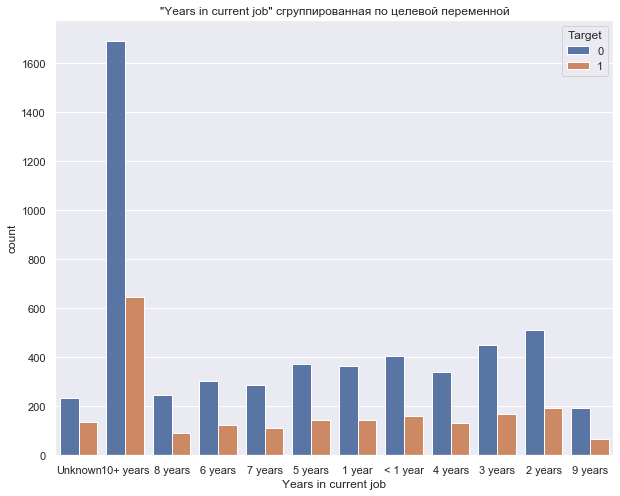

In [64]:
grouped_by_target(df_train, 'Years in current job', 'Credit Default')

In [65]:
df_train['Is_Years_in_current_job'] = df_train['Years in current job'].map({'Unknown': '-1',
                                                                            '< 1 year': '0',
                                                                            '1 year': '1',
                                                                            '2 years': '2',
                                                                            '3 years': '3',
                                                                            '4 years': '4',
                                                                            '5 years': '5',
                                                                            '6 years': '6',
                                                                            '7 years': '7',
                                                                            '8 years': '8',
                                                                            '9 years': '9',
                                                                            '10+ years': '10'}).astype(int)

In [66]:
df_test['Is_Years_in_current_job'] = df_test['Years in current job'].map({'Unknown': '-1',
                                                                            '< 1 year': '0',
                                                                            '1 year': '1',
                                                                            '2 years': '2',
                                                                            '3 years': '3',
                                                                            '4 years': '4',
                                                                            '5 years': '5',
                                                                            '6 years': '6',
                                                                            '7 years': '7',
                                                                            '8 years': '8',
                                                                            '9 years': '9',
                                                                            '10+ years': '10'}).astype(int)

__Home Ownership__

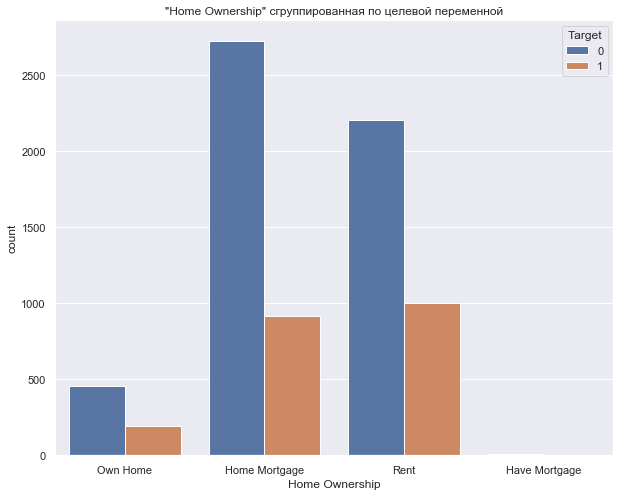

In [67]:
grouped_by_target(df_train, 'Home Ownership', 'Credit Default')

In [68]:
combine_into_category_table(df_train, 'Home Ownership', 'Credit Default', 'ID')

,Own Home,Home Mortgage,Rent,Have Mortgage
Own Home,,False,True,True
Home Mortgage,False,,False,True
Rent,True,False,,True
Have Mortgage,True,True,True,


Очевидно, что значения "Own Home", "Rent" и "Have Mortgage" можно собрать в одно значение

In [69]:
df_train['Is_Home_Ownership'] = df_train['Home Ownership'].map({'Own Home':'0', 
                                                                'Rent':'0', 
                                                                'Have Mortgage':'0', 
                                                                'Home Mortgage':'1'}).astype(int)

In [70]:
df_test['Is_Home_Ownership'] = df_test['Home Ownership'].map({'Own Home':'0', 
                                                                'Rent':'0', 
                                                                'Have Mortgage':'0', 
                                                                'Home Mortgage':'1'}).astype(int)

__Purpose__

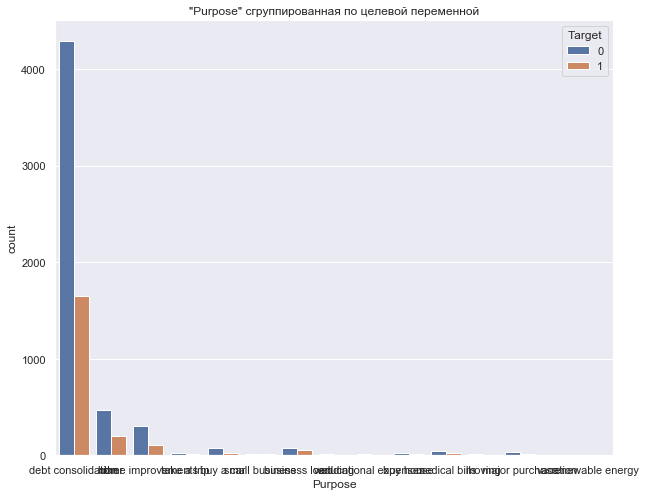

In [71]:
grouped_by_target(df_train, 'Purpose', 'Credit Default')

In [72]:
combine_into_category_table(df_train, 'Purpose', 'Credit Default', 'ID')

,debt consolidation,other,home improvements,take a trip,buy a car,small business,business loan,wedding,educational expenses,buy house,medical bills,moving,major purchase,vacation,renewable energy
debt consolidation,,True,True,True,True,False,False,True,True,True,True,True,True,True,False
other,True,,True,True,True,False,False,True,True,True,True,True,True,True,False
home improvements,True,True,,True,True,False,False,True,True,True,True,True,True,True,False
take a trip,True,True,True,,True,False,True,True,True,True,True,True,True,True,False
buy a car,True,True,True,True,,False,False,True,True,True,True,True,True,True,False
small business,False,False,False,False,False,,True,True,False,False,False,False,False,True,False
business loan,False,False,False,True,False,True,,True,False,True,True,True,False,True,False
wedding,True,True,True,True,True,True,True,,True,True,True,True,True,True,False
educational expenses,True,True,True,True,True,False,False,True,,True,True,True,True,True,False
buy house,True,True,True,True,True,False,True,True,True,,True,True,True,True,False


Очевидно, что все значения показателя, кроме "small business", "business loan" и "renewable energy" можно собрать в одно значение.

In [73]:
df_train['Is_Purpose'] = df_train['Purpose'].map({'debt consolidation':'other',
                                                  'other':'other',
                                                  'home improvements':'other',
                                                  'take a trip':'other',
                                                  'buy a car':'other',
                                                  'small business':'small business',
                                                  'business loan':'business loan',
                                                  'wedding':'other',
                                                  'educational expenses':'other',
                                                  'buy house':'other',
                                                  'medical bills':'other',
                                                  'moving':'other',
                                                  'major purchase':'other',
                                                  'vacation':'other',
                                                  'renewable energy':'renewable energy'})

In [74]:
df_test['Is_Purpose'] = df_test['Purpose'].map({'debt consolidation':'other',
                                                'other':'other',
                                                'home improvements':'other',
                                                'take a trip':'other',
                                                'buy a car':'other',
                                                'small business':'small business',
                                                'business loan':'business loan',
                                                'wedding':'other',
                                                'educational expenses':'other',
                                                'buy house':'other',
                                                'medical bills':'other',
                                                'moving':'other',
                                                'major purchase':'other',
                                                'vacation':'other',
                                                'renewable energy':'renewable energy'})

In [75]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Is_Purpose'], prefix='Is_Purpose')], axis=1)

In [76]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['Is_Purpose'], prefix='Is_Purpose')], axis=1)

### 5. Анализ данных

#### Выделение целевой переменной и групп признаков

In [77]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [78]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [79]:
NEW_FEATURE_NAMES

Index(['ID', 'Is_Term', 'Is_Years_in_current_job', 'Is_Home_Ownership',
       'Is_Purpose', 'Is_Purpose_business loan', 'Is_Purpose_other',
       'Is_Purpose_renewable energy', 'Is_Purpose_small business'],
      dtype='object')

#### Анализ целевой переменной

__Обзор распределения__

In [80]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Есть некоторая диспропорция

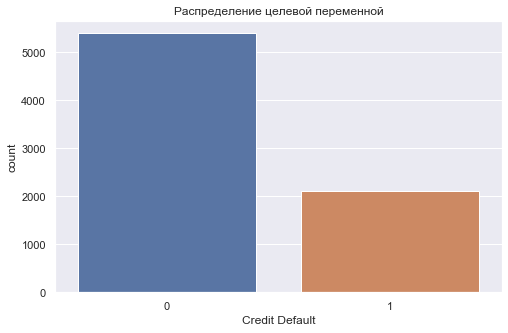

In [81]:
plt.figure(figsize=(8, 5))
sns.countplot(x=TARGET_NAME, data=df_train)
plt.title('Распределение целевой переменной')
plt.show()

__Корреляция с базовыми признаками__

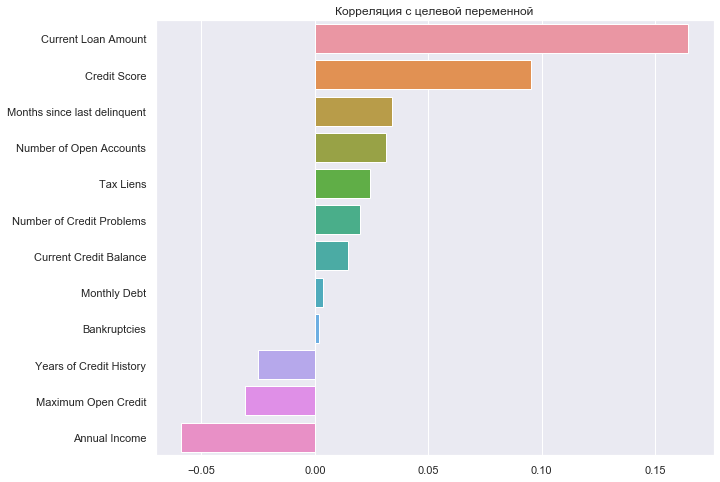

In [82]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Корреляция с целевой переменной')
plt.show()

Оценка признака "Purpose" в разрезе целевой переменной

__Оценка признака "Number of Open Accounts" в разрезе целевой переменной__

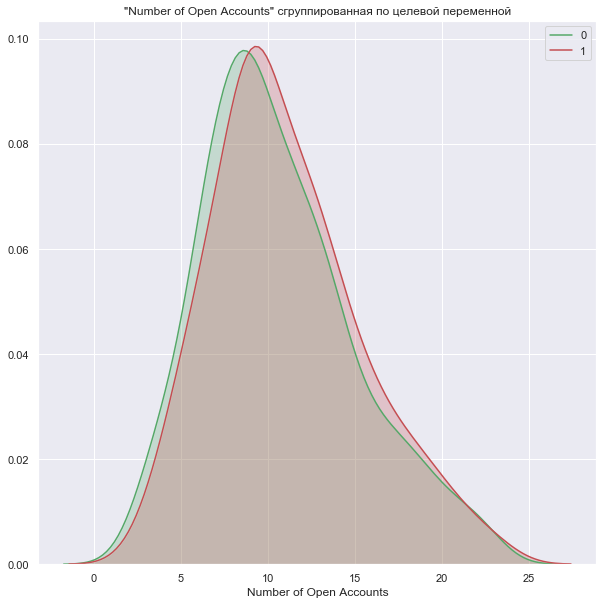

In [83]:
grouped_by_target_kde(df_train, 'Number of Open Accounts', TARGET_NAME)

__Наблюдение__

Похоже что две группы, полученные в результате разбиения признака "Number of Open Accounts" по целевой переменной, имеют хоть и близкое, но все-таки различные распределения, что означает, что между признаком "Number of Open Accounts" и целевой переменной, возможно, существует некоторая функциональная зависимость.

__Гипотеза__

- Нулевая гипотеза: средние значения в двух независимых выборках равны
- Альтернативная гипотеза: средние значения в двух независимых выборках различаются
- Критерий: критерий Стьюдента (t-тест) и его аналоги
- Уровень значимости  α : 0.05
- Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений. Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

_Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка_

In [84]:
limit_bal_with_target_s = df_train[['Number of Open Accounts', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Number of Open Accounts']
shapiro(limit_bal_s)

(0.9679663181304932, 4.8940594686661815e-14)

По полученному значению p-value, которое сильно меньше 0,05, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

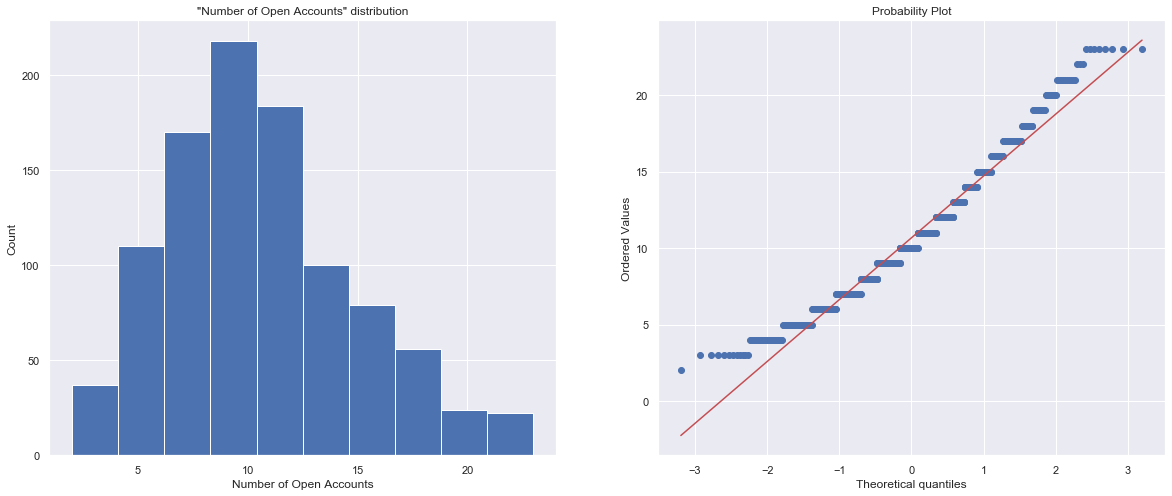

In [85]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Number of Open Accounts')
ax1.set_ylabel('Count')
ax1.set_title('"Number of Open Accounts" distribution')
limit_bal_s.hist()

plt.subplot(122)
probplot(limit_bal_s, dist='norm', plot=plt)

plt.show()

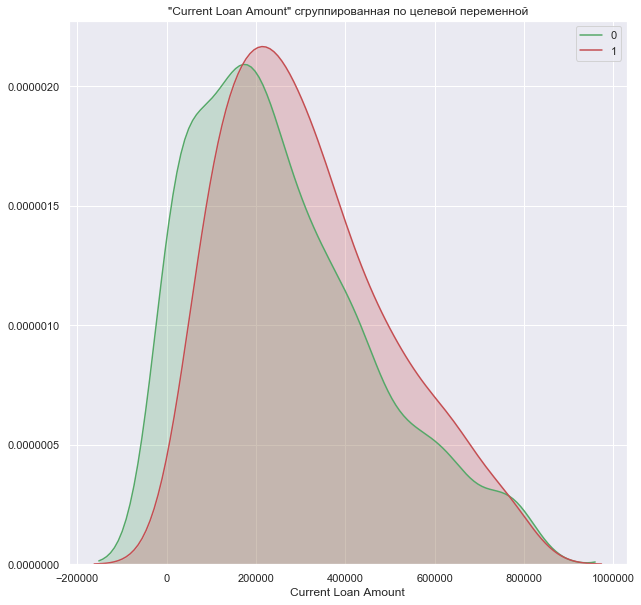

In [86]:
limit_bal_with_target_s = df_train[['Current Loan Amount', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Current Loan Amount']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 10))

sns.kdeplot(limit_bal_target_0, shade=True, label='0', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='1', color='r')

plt.xlabel('Current Loan Amount')
plt.title('"Current Loan Amount" сгруппированная по целевой переменной')
plt.show()

In [87]:
# plt.figure(figsize=(10, 8))
# sns.countplot(x="Current Loan Amount", hue=TARGET_NAME, data=df_train)
# plt.title('"Current Loan Amount" сгруппированная по целевой переменной')
# plt.legend(title='Целевая переменная', loc='upper right')
# plt.show()

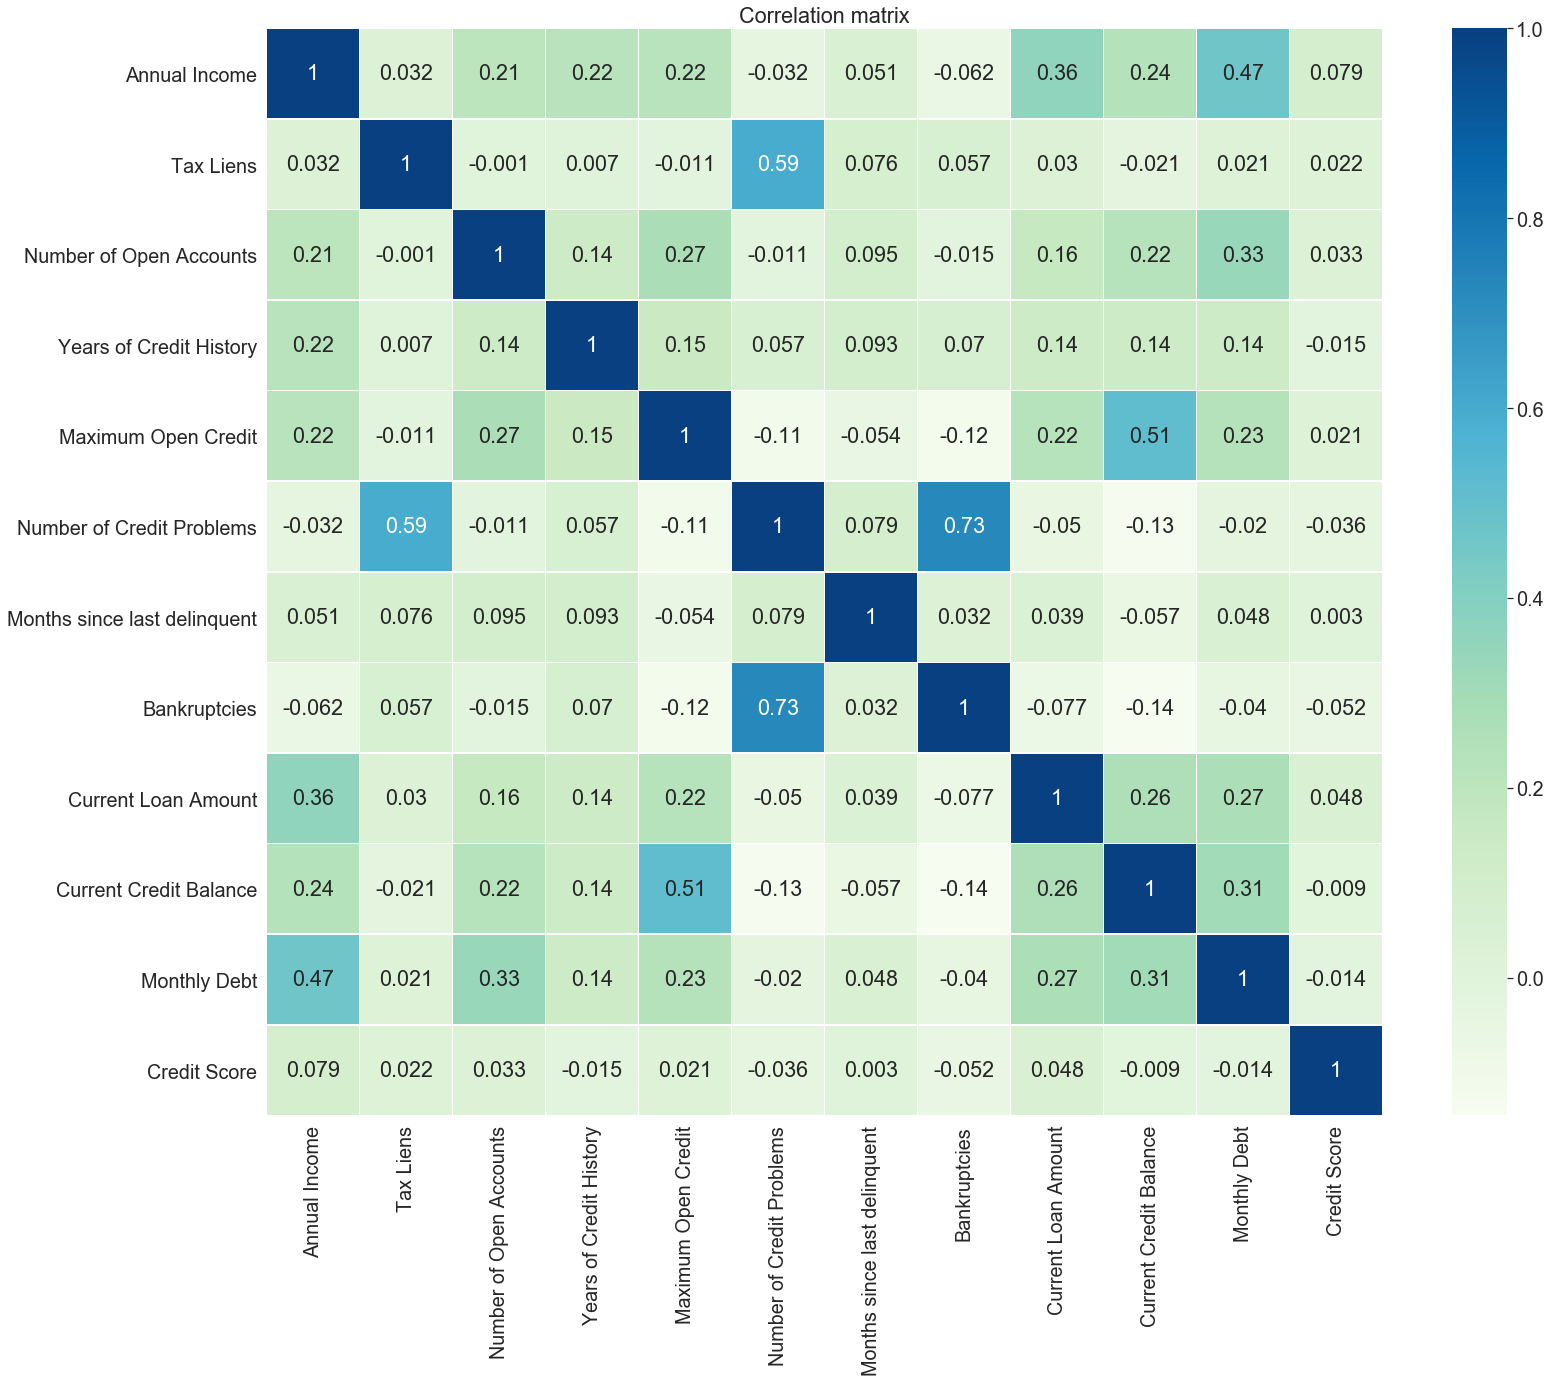

In [88]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.8)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()